In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import os
import glob
import time
import copy

import PIL.Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor, Lambda
from torch.utils.data import DataLoader

In [2]:
train_df = pd.read_csv("./train.csv")
train_df.head()

,id,landmark_id
0,동탄_복합문화센터_057,114
1,동탄_복합문화센터_110,114
2,동탄_복합문화센터_016,114
3,동탄_복합문화센터_022,114
4,동탄_복합문화센터_052,114


In [3]:
train_df.shape

(88102, 2)

In [4]:
submission_df = pd.read_csv('./sample_submission.csv')
submission_df.head()

,id,landmark_id,conf
0,xlf1tgh2ih,1,1
1,68a3ot4osk,1,1
2,si2lek4u0a,1,1
3,rmtqxhipnv,1,1
4,2flmjdud0e,1,1


In [5]:
test_path = './test_set'
test_img_list = glob.glob(os.path.join(test_path, '*', '*.JPG'))
len(test_img_list)

37964

In [6]:
cat_df = pd.read_csv("./category.csv")
cat_df.head()

,landmark_id,landmark_name
0,0,금천구청
1,1,두리랜드
2,2,이대원 장군묘
3,3,성공회대학교
4,4,송상현공 동상


In [7]:
num_classes =  train_df['landmark_id'].nunique()
num_classes

1049

In [8]:
train_path = './train_set_img'
train_img_list = glob.glob(os.path.join(train_path, '*', '*', '*.JPG'))

In [9]:
len(train_img_list)

88102

In [10]:
train_img_df = pd.DataFrame(train_img_list, columns=['filepath'])
train_img_df['filename'] = train_img_df['filepath'].apply(lambda x: os.path.basename(x))
train_img_df['name'] = train_img_df['filename'].apply(lambda x: x.split('.JPG')[0].split('_')[:-1])
train_img_df['name'] = train_img_df['name'].apply(lambda x: '_'.join(x) if len(x)>1 else x[0])

In [11]:
train_img_df['id'] = train_img_df['filename'].apply(lambda x: x.split('.JPG')[0])

In [12]:
train_img_df.head()

,filepath,filename,name,id
0,./train_set_img\경기도\G 챔피언스 파크\G_챔피언스_파크_002.JPG,G_챔피언스_파크_002.JPG,G_챔피언스_파크,G_챔피언스_파크_002
1,./train_set_img\경기도\G 챔피언스 파크\G_챔피언스_파크_003.JPG,G_챔피언스_파크_003.JPG,G_챔피언스_파크,G_챔피언스_파크_003
2,./train_set_img\경기도\G 챔피언스 파크\G_챔피언스_파크_004.JPG,G_챔피언스_파크_004.JPG,G_챔피언스_파크,G_챔피언스_파크_004
3,./train_set_img\경기도\G 챔피언스 파크\G_챔피언스_파크_006.JPG,G_챔피언스_파크_006.JPG,G_챔피언스_파크,G_챔피언스_파크_006
4,./train_set_img\경기도\G 챔피언스 파크\G_챔피언스_파크_007.JPG,G_챔피언스_파크_007.JPG,G_챔피언스_파크,G_챔피언스_파크_007


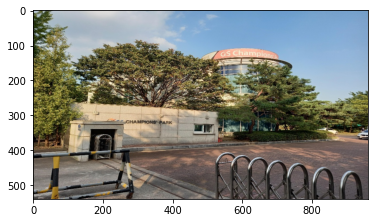

In [13]:
import matplotlib.pyplot as plt
import matplotlib.image as img
from PIL import Image

smp1 = img.imread(train_img_df['filepath'].values[0])
plt.imshow(smp1)
plt.show()

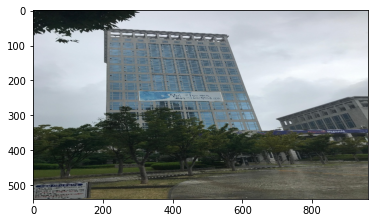

In [14]:
smpt = img.imread(test_img_list[0])
plt.imshow(smpt)
plt.show()

In [15]:
train_img_df = pd.merge(train_img_df, train_df, how='left', on = 'id')
train_img_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88102 entries, 0 to 88101
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   filepath     88102 non-null  object
 1   filename     88102 non-null  object
 2   name         88102 non-null  object
 3   id           88102 non-null  object
 4   landmark_id  88102 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 4.0+ MB


In [16]:
train_img_df.head()

,filepath,filename,name,id,landmark_id
0,./train_set_img\경기도\G 챔피언스 파크\G_챔피언스_파크_002.JPG,G_챔피언스_파크_002.JPG,G_챔피언스_파크,G_챔피언스_파크_002,644
1,./train_set_img\경기도\G 챔피언스 파크\G_챔피언스_파크_003.JPG,G_챔피언스_파크_003.JPG,G_챔피언스_파크,G_챔피언스_파크_003,644
2,./train_set_img\경기도\G 챔피언스 파크\G_챔피언스_파크_004.JPG,G_챔피언스_파크_004.JPG,G_챔피언스_파크,G_챔피언스_파크_004,644
3,./train_set_img\경기도\G 챔피언스 파크\G_챔피언스_파크_006.JPG,G_챔피언스_파크_006.JPG,G_챔피언스_파크,G_챔피언스_파크_006,644
4,./train_set_img\경기도\G 챔피언스 파크\G_챔피언스_파크_007.JPG,G_챔피언스_파크_007.JPG,G_챔피언스_파크,G_챔피언스_파크_007,644


In [17]:
train_set,val_set = train_test_split(train_img_df[['filepath','landmark_id']], test_size=.2, random_state=42, stratify = train_img_df['landmark_id'])

In [18]:
train_set

,filepath,landmark_id
63304,./train_set_img\서울시\숭실대학교\숭실대학교_013.JPG,148
25451,./train_set_img\경기도\하피랜드\하피랜드_085.JPG,236
6989,./train_set_img\경기도\대화 도서관\대화_도서관_061.JPG,391
70528,./train_set_img\서울시\중부시장\중부시장_116.JPG,859
1995,./train_set_img\경기도\고양문화원\고양문화원_110.JPG,777
...,...,...
53183,./train_set_img\서울시\동작구청\동작구청_049.JPG,780
50958,./train_set_img\서울시\단성사\단성사_026.JPG,103
7455,./train_set_img\경기도\덕풍5일장\덕풍5일장_088.JPG,108
11225,./train_set_img\경기도\부천 종합터미널\부천_종합터미널_033.JPG,752


In [19]:
class CustomImageDataset(Dataset):
    def __init__(self, dataset, transform=None, target_transform=None):
        self.dataset = dataset.reset_index(drop=True)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return self.dataset.shape[0]

    def __getitem__(self, idx):
        image = Image.open(self.dataset.iloc[idx,0])
        label = self.dataset.iloc[idx,1]
        if self.transform:
            image = self.transform(image)
        elif self.transform==None:
            image = transforms.ToTensor()(image)
        
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [20]:
imgdatagen = CustomImageDataset(train_set)
traindataloader = torch.utils.data.DataLoader(imgdatagen, batch_size=16, shuffle=True)

In [21]:
next(iter(imgdatagen))

(tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [0.5569, 0.5529, 0.5216,  ..., 0.3843, 0.3529, 0.4902],
          [0.5333, 0.5451, 0.5216,  ..., 0.4235, 0.3569, 0.4980],
          [0.5137, 0.5059, 0.5098,  ..., 0.4471, 0.4824, 0.4510]],
 
         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [0.5020, 0.4980, 0.4667,  ..., 0.4157, 0.3843, 0.5216],
          [0.4784, 0.4902, 0.4667,  ..., 0.4588, 0.3804, 0.5255],
          [0.4588, 0.4510, 0.4549,  ..., 0.4824, 0.5098, 0.4784]],
 
         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ...,

In [22]:
# 학습을 위해 데이터 증가(augmentation) 및 일반화(normalization)
# 검증을 위한 일반화
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [23]:
train_nb = 64
val_nb = 32

imgdatagen = CustomImageDataset(train_set, transform=data_transforms['train'])
traindataloader = torch.utils.data.DataLoader(imgdatagen, batch_size=train_nb, shuffle=True)

imgdatagen2 = CustomImageDataset(val_set, transform=data_transforms['val'])
valdataloader = torch.utils.data.DataLoader(imgdatagen2, batch_size=val_nb, shuffle=True)

In [24]:
next(iter(traindataloader))

[tensor([[[[ 0.2624,  0.0056,  0.5193,  ...,  0.3138,  0.2967,  0.3138],
           [ 0.1083,  0.0569,  0.4166,  ...,  0.2967,  0.2967,  0.2967],
           [ 0.2967, -0.0287,  0.2967,  ...,  0.3138,  0.3138,  0.3138],
           ...,
           [-1.0219, -1.1418, -1.1075,  ..., -0.8507, -0.7479, -0.7479],
           [-0.9705, -1.1418, -1.0562,  ..., -0.7650, -0.8164, -0.7650],
           [-1.0048, -1.1075, -1.0562,  ..., -0.2856, -0.7993, -0.7479]],
 
          [[ 0.6779,  0.3978,  0.9580,  ...,  1.0630,  1.0455,  1.0630],
           [ 0.5378,  0.4853,  0.8704,  ...,  1.0455,  1.0455,  1.0455],
           [ 0.8004,  0.4678,  0.8004,  ...,  1.0630,  1.0630,  1.0630],
           ...,
           [-0.8277, -0.9678, -0.9153,  ..., -0.7752, -0.5651, -0.4951],
           [-0.7927, -0.9678, -0.8803,  ..., -0.7927, -0.6176, -0.4776],
           [-0.8277, -0.9503, -0.9153,  ..., -0.4251, -0.6001, -0.4251]],
 
          [[ 0.8448,  0.5659,  1.1062,  ...,  1.9777,  1.9603,  1.9777],
           [ 

In [25]:
use_gpu = torch.cuda.is_available()

In [26]:
dataloaders = {'train':traindataloader, 'val':valdataloader}

In [27]:
torch.cuda.is_available()

True

In [28]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [29]:
print('cuda index:', torch.cuda.current_device())
print('gpu 개수:', torch.cuda.device_count())
print('graphic name:', torch.cuda.get_device_name())

cuda index: 0
gpu 개수: 1
graphic name: GeForce GTX 1660 SUPER


In [30]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 각 에폭(epoch)은 학습 단계와 검증 단계를 갖습니다.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 학습 모드로 설정
            else:
                model.eval()   # 모델을 평가 모드로 설정

            running_loss = 0.0
            running_corrects = 0

            # 데이터를 반복
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 매개변수 경사도를 0으로 설정
                optimizer.zero_grad()

                # 순전파
                # 학습 시에만 연산 기록을 추적
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 학습 단계인 경우 역전파 + 최적화
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 통계
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
            
            
            if phase == 'train':
                dataset_size = train_set.shape[0]
            else:
                dataset_size = val_set.shape[0]
                
            epoch_loss = running_loss / dataset_size
            epoch_acc = running_corrects.double() / dataset_size

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # 모델을 깊은 복사(deep copy)함
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 가장 나은 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)
    return model

In [31]:
#resnet fine tuning
model_ft = models.mobilenet_v2(pretrained=True)
model_ft.classifier[1] = nn.Linear(model_ft.last_channel, num_classes)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# 모든 매개변수들이 최적화되었는지 관찰
optimizer_ft = optim.Adam(model_ft.parameters(), lr=1e-3, weight_decay=1e-5)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [32]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)

Epoch 0/19
----------
train Loss: 4.4355 Acc: 0.1950
val Loss: 1.4837 Acc: 0.6493

Epoch 1/19
----------
train Loss: 1.6071 Acc: 0.6277
val Loss: 0.6873 Acc: 0.8310

Epoch 2/19
----------
train Loss: 1.0280 Acc: 0.7518
val Loss: 0.4491 Acc: 0.8892

Epoch 3/19
----------
train Loss: 0.8191 Acc: 0.8008
val Loss: 0.3440 Acc: 0.9149

Epoch 4/19
----------
train Loss: 0.6908 Acc: 0.8285
val Loss: 0.3499 Acc: 0.9103

Epoch 5/19
----------
train Loss: 0.6111 Acc: 0.8465
val Loss: 0.2905 Acc: 0.9297

Epoch 6/19
----------
train Loss: 0.5497 Acc: 0.8616
val Loss: 0.2588 Acc: 0.9328

Epoch 7/19
----------
train Loss: 0.3233 Acc: 0.9199
val Loss: 0.1305 Acc: 0.9698

Epoch 8/19
----------
train Loss: 0.2739 Acc: 0.9323
val Loss: 0.1234 Acc: 0.9711

Epoch 9/19
----------
train Loss: 0.2580 Acc: 0.9352
val Loss: 0.1197 Acc: 0.9722

Epoch 10/19
----------
train Loss: 0.2414 Acc: 0.9402
val Loss: 0.1145 Acc: 0.9746

Epoch 11/19
----------
train Loss: 0.2373 Acc: 0.9409
val Loss: 0.1110 Acc: 0.9746

Ep

In [33]:
torch.save(model_ft.state_dict(), 'pytorch_mobilenetv2')